<a href="https://colab.research.google.com/github/lee-j-j/LJJ/blob/main/ex10_mlp%2Ccnn_%EA%B0%9C%2C%EA%B3%A0%EC%96%91%EC%9D%B4_%EC%9D%B4%EC%A7%84%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 목표
- 개, 고양이 데이터 이미지를 배열로 변환 작업을 진행해보자 (이미지 데이터 전처리)
  - 이미지 자체를 저장소 업로드하는 것보다 배열로 변환했을 때 용량 소모가 적음
- mlp 이미지 데이터 이진 분류
- cnn 이미지 데이터 이진 분류
- 성능을 높이기 위한 노력을 진행해보자
  - 이미지 증식
  - 전이학습

In [3]:
# 개, 고양이 배열 데이터 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = np.load('./data/np_cat_vs_dog.npz')
data

In [5]:
len(data)
# 각각의 변수에 데이터 분리해서 담아주기
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# 크기확인
print('훈련셋 : ', X_train.shape, y_train.shape)
print('테스트셋 : ', X_test.shape, y_test.shape)

훈련셋 :  (2000, 224, 224, 3) (2000,)
테스트셋 :  (1000, 224, 224, 3) (1000,)


#### mlp 모델 생성

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten # 1차원 펴주는 도구
from tensorflow.keras.callbacks import EarlyStopping # 조기 학습 중단 도구

In [7]:
# 1. 모델 설계
# 뼈대 구축
mlp_model = Sequential()

# 입력(3차원 → 1차원)
mlp_model.add(Flatten(input_shape = (224,224,3))) # 행,열,채널수(컬러) → 1차원 데이터 연결

# 중간층
mlp_model.add(Dense(units = 256, activation = 'relu'))
mlp_model.add(Dense(units = 128, activation = 'relu'))
mlp_model.add(Dense(units = 64, activation = 'relu'))

# 출력층 (이진분류 : units = 1, acti_f = sigmoid)
mlp_model.add(Dense(units = 1, activation = 'sigmoid'))
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 256)               38535424  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 38576641 (147.16 MB)
Trainable params: 38576641 (147.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# 번역 : compile
# pc가 이해하도록 번역하는 작업
# loss, optimizer, metrics
mlp_model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [9]:
# 조기학습중단 설정
# 검증 정확도 기준, 5번 기다림
f_ea = EarlyStopping(monitor = "val_accuracy", patience=5)

# 학습, 검증데이터 분리 30%, batchsize 64, 반복횟수 50, 조기학습중단 연결
mlp_his = mlp_model.fit(X_train, y_train, validation_split=0.3, epochs = 50, batch_size = 64, callbacks = [f_ea])
# validation_split 대신 validation_data를 쓸 때 : X_val, y_val 데이터를 따로 만들어 두어야 함!


Epoch 1/50
22/22 [==============================] - 7s 37ms/step - loss: 2243.8792 - accuracy: 0.5943 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
22/22 [==============================] - 0s 21ms/step - loss: 1876.1394 - accuracy: 0.5921 - val_loss: 545.2458 - val_accuracy: 0.3450
Epoch 3/50
22/22 [==============================] - 0s 18ms/step - loss: 1570.7332 - accuracy: 0.5936 - val_loss: 1260.9152 - val_accuracy: 0.0883
Epoch 4/50
22/22 [==============================] - 0s 19ms/step - loss: 868.1638 - accuracy: 0.6107 - val_loss: 82.3196 - val_accuracy: 0.8117
Epoch 5/50
22/22 [==============================] - 0s 18ms/step - loss: 434.3546 - accuracy: 0.6250 - val_loss: 1305.0403 - val_accuracy: 0.0117
Epoch 6/50
22/22 [==============================] - 0s 22ms/step - loss: 266.9550 - accuracy: 0.6371 - val_loss: 230.3646 - val_accuracy: 0.3733


In [10]:
# test 데이터 활용해서 평가하기
# 모델.score(문제, 답) → 머신러닝 모델 평가하는 함수 (sklearn) * sk? science kit!
# 모델.evaluate(문제, 답) → 딥러닝 모델 평가하는 함수 (tensorflow.keras)
mlp_model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 5ms/step - loss: 144.3289 - accuracy: 0.5630


[144.32887268066406, 0.5630000233650208]

#### cnn 모델 생성
- 1. 모델 설계 (cnn층)
- 2. 모델 학습 및 평가 방법 설정
- 3. 모델 학습 및 시각화
- 4. 모델 평가 및 예측

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout # Conv2D : 대상에 집중하게 만들어주는 역할

In [12]:
# cnn 신경망 구조를 설계
# 뼈대 생성
cnn_model = Sequential()

# 대상에 집중! → 중요한 특성에 집중! → 특성 추출
# 특성 추출부(층) - conv(합성곱)
# (224,224,3) : 224행, 224열, 3개의 채널(컬러 이미지)
cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', input_shape=(224,224,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = 2)) # padding 기본값 =  vaild라서 여기서는 조금 줄어들음

cnn_model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = 2))

cnn_model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = 2))

# 개, 고양이 분류부(전결합층) - mlp(입력(1차원으로 펴주는 기능 필요), 중간, 출력층(이진분류))
cnn_model.add(Flatten()) # 특성 추출부를 거친 후의 input_shape가 자동으로 전달 됨 - 생략
cnn_model.add(Dense(512, activation = 'relu')) # 중간층
cnn_model.add(Dense(1, activation = 'sigmoid')) # 출력층

# 모델 정보 확인
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)      

In [13]:
# compile
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit
cnn_his = cnn_model.fit(X_train, y_train, validation_split=0.3, epochs=50, batch_size=64, callbacks=[f_ea])

Epoch 1/50
22/22 [==============================] - 13s 197ms/step - loss: 246.2308 - accuracy: 0.5814 - val_loss: 0.9226 - val_accuracy: 0.0100
Epoch 2/50
22/22 [==============================] - 2s 102ms/step - loss: 0.6217 - accuracy: 0.7129 - val_loss: 1.3282 - val_accuracy: 0.0000e+00
Epoch 3/50
22/22 [==============================] - 2s 105ms/step - loss: 0.5728 - accuracy: 0.7200 - val_loss: 0.9511 - val_accuracy: 0.0917
Epoch 4/50
22/22 [==============================] - 2s 105ms/step - loss: 0.5107 - accuracy: 0.7650 - val_loss: 1.3873 - val_accuracy: 0.2233
Epoch 5/50
22/22 [==============================] - 2s 104ms/step - loss: 0.4352 - accuracy: 0.8150 - val_loss: 1.2672 - val_accuracy: 0.2750
Epoch 6/50
22/22 [==============================] - 2s 98ms/step - loss: 0.3873 - accuracy: 0.8293 - val_loss: 2.2947 - val_accuracy: 0.1700
Epoch 7/50
22/22 [==============================] - 2s 102ms/step - loss: 0.2852 - accuracy: 0.8793 - val_loss: 2.0182 - val_accuracy: 0.2967


In [ ]:
# 과대적합 보여짐 (accuracy - 높음, val_accuracy - 높지 않음)
# 왜 이렇게 학습했을까?
# cnn 특성에 집중 → val 예측 성능은 떨어지는 상태
# 데이터는 복잡한 데이터일 수 있음
# 반대로 모델은 너무 단순할 수 있음

# 과대적합 피하는 방법
# 학습조기중단
# 드롭아웃
# 데이터확장(증식) - 이미지 회전, 확대, 반전, 이동 등

In [14]:
# 평가
# cnn_model.evaluate(X_test, y_test)[1] : 정확도만 확인
cnn_model.evaluate(X_test, y_test) # accuracy = 58%

32/32 [==============================] - 1s 21ms/step - loss: 3.2182 - accuracy: 0.6130


[3.218212604522705, 0.6129999756813049]

#### 데이터 확장하여 cnn 모델 학습 진행하기

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # 이미지 증식

In [17]:
# 증식할 데이터 경로 설정
train_dir = "./data/dog_vs_cat/cats_and_dogs_filtered/train"
test_dir = "./data/dog_vs_cat/cats_and_dogs_filtered/test"

# 변형 형식 설정
# 0~255 범위의 수치값을 0~1 사이로 변환
train_gen = ImageDataGenerator(rescale = 1./255,
                               zoom_range = 0.2, # 축소, 확대 범위 0.8 ~ 1.2배
                               horizontal_flip=True) # 수평 뒤집기

# 모델을 일반화 시키는 데이터는 학습용 데이터! (train에 증식 적용)
test_gen = ImageDataGenerator(rescale = 1./255) # rescale은 적용해야함 (train의 영향으로 인해 예측도 0~1로 나오기 때문)

In [18]:
# 증식하기 위한 설정 필요
train_generator = train_gen.flow_from_directory(train_dir, # 폴더 경로 연결
                                                target_size = (224,224), # 변환할 이미지 크기
                                                batch_size = 10, # 한번에 변환할 이미지 수
                                                class_mode = 'binary') # 라벨번호는 0번부터 시작, 폴더는 알파벳 순서로 읽어들임.

test_generator = test_gen.flow_from_directory(test_dir,
                                              target_size = (224,224),
                                              batch_size = 10,
                                              class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
# cnn 신경망 구조를 설계
# 뼈대 생성
cnn_model2 = Sequential() # Ctrl + Shift + L : colab에서 같은 변수 모두 선택(변수 이름 한꺼번에 변경 가능)

# 대상에 집중! → 중요한 특성에 집중! → 특성 추출
# 특성 추출부(층) - conv(합성곱)
# (224,224,3) : 224행, 224열, 3개의 채널(컬러 이미지)
cnn_model2.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', input_shape=(224,224,3), activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size = 2)) # padding 기본값 =  vaild라서 여기서는 조금 줄어들음

cnn_model2.add(Conv2D(64, (3,3), padding='same', activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size = 2))
cnn_model2.add(Dropout(0.2)) # 20% 특성은 제외하고 학습 (일정 비율만큼 랜덤하게 중간층의 뉴런을 비활성화)

cnn_model2.add(Conv2D(128, (3,3), padding='same', activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size = 2))

# 개, 고양이 분류부(전결합층) - mlp(입력(1차원으로 펴주는 기능 필요), 중간, 출력층(이진분류))
cnn_model2.add(Flatten()) # 특성 추출부를 거친 후의 input_shape가 자동으로 전달 됨 - 생략
cnn_model2.add(Dense(512, activation = 'relu')) # 중간층
cnn_model2.add(Dropout(0.2)) # 20% 특성은 제외하고 학습 - 특성의 복잡도를 줄임
cnn_model2.add(Dense(1, activation = 'sigmoid')) # 출력층

# 모델 정보 확인
cnn_model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)      

In [20]:
# 컴파일
cnn_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# 학습 - 이미지 증식 설정 연결
# 이미지 증식을 하고 학습할 경우, 학습 진행이 들쭉날쭉하는 경향이 있을 수 있음
# 그래서 조기학습중단(EarlyStopping)을 연결x 경우 많음
# 반복횟수도 크게 설정하는 경우가 있음
cnn_his2 = cnn_model2.fit_generator(generator = train_generator,
                                    validation_data = test_generator,
                                    epochs = 20)

<ipython-input-21-83f0e684f83d>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_his2 = cnn_model2.fit_generator(generator = train_generator,


Epoch 1/20
200/200 [==============================] - 800s 4s/step - loss: 0.8557 - accuracy: 0.5270 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/20
200/200 [==============================] - 35s 176ms/step - loss: 0.6891 - accuracy: 0.5275 - val_loss: 0.6875 - val_accuracy: 0.5400
Epoch 3/20
200/200 [==============================] - 35s 174ms/step - loss: 0.6862 - accuracy: 0.5565 - val_loss: 0.7498 - val_accuracy: 0.5000
Epoch 4/20
200/200 [==============================] - 36s 181ms/step - loss: 0.6773 - accuracy: 0.5790 - val_loss: 0.6634 - val_accuracy: 0.6410
Epoch 5/20
200/200 [==============================] - 34s 172ms/step - loss: 0.6653 - accuracy: 0.6115 - val_loss: 0.6370 - val_accuracy: 0.6480
Epoch 6/20
200/200 [==============================] - 36s 179ms/step - loss: 0.6373 - accuracy: 0.6455 - val_loss: 0.6829 - val_accuracy: 0.5620
Epoch 7/20
200/200 [==============================] - 34s 171ms/step - loss: 0.6202 - accuracy: 0.6700 - val_loss: 0.6059 - val_accu

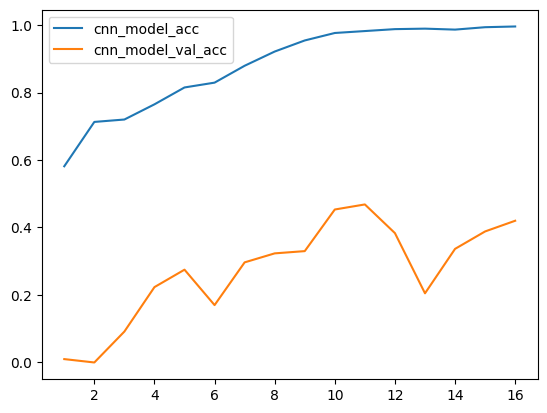

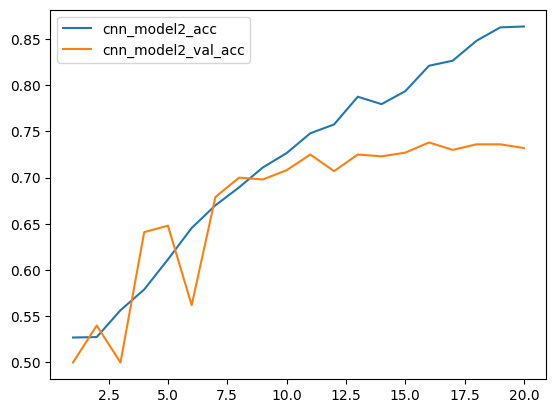

In [28]:
# cnn_model → cnn_his
# 이미지 증식 학습 cnn_model2 → cnn_his2
# 선 그래프로 시각화하여 비교해보기
# 범례표시
# 도화지 2장에 2개의 선 그래프 그려보기


plt.plot(range(1,len(cnn_his.history['accuracy'])+1), cnn_his.history['accuracy'], label = 'cnn_model_acc')
plt.plot(range(1,len(cnn_his.history['val_accuracy'])+1), cnn_his.history['val_accuracy'], label = 'cnn_model_val_acc')

plt.legend()
plt.show()

plt.plot(range(1,len(cnn_his2.history['accuracy'])+1), cnn_his2.history['accuracy'], label = 'cnn_model2_acc')
plt.plot(range(1,len(cnn_his2.history['val_accuracy'])+1), cnn_his2.history['val_accuracy'], label = 'cnn_model2_val_acc')

plt.legend()
plt.show()

# 이미지 증식을 통해 과대적합을 해소한 것을 확인할 수 있음
# 이미지 증식으로 모델의 성능 향상시킴
# 이미지 증식의 단점으로 학습하는 시간이 오래 걸림

#### 전이학습
  - 다른 사람이 만들어놓은 모델을 사용해보자! → 학습이 되어있음 (시간 단축)
  - 완전히 똑같은 데이터로 학습한 것은 아님 (레이블이 다를 수 있음)
  - 현재 우리 목표 : 개 vs 고양이
  - 전이학습 모델 : 사자 vs 호랑이 vs 코끼리
  - 분류하려는 대상은 다르지만 판단한다는 기준은 비슷할 수 있으니 가져와서 활용해보자

In [30]:
from tensorflow.keras.applications import VGG16
# VGG16 : 사전 학습된 모델 (pretrained model)
vgg16 = VGG16(include_top = False, # include_top : 분류부 (전결합층) → 분류부는 다르게 쓸거라서 False(안 가져옴)
              weights = 'imagenet', # weights = 'imagenet' : imagenet 경진대회 데이터 셋을 보며 학습한 모델의 가중치
                                    # imagenet 클래스 : 1000개의 사물, 100만장 사진 → 성능이 뛰어날 확률 높음
              input_shape = (224,224,3))

vgg16.summary() # 분류부 추가 후 우리 데이터를 추가로 학습

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [31]:
# conv 미세하게 조정
# 동결 (가중치 갱신을 막음) → 학습 불가능하게 설정
# vgg16은 100만장의 사진으로 학습이 되어 있음 = 성능이 좋음
# 학습시 가중치가 갱신이 되어버리면 기존에 학습된 내용이 훼손이 됨 → 성능이 떨어질 수 있음
vgg16.trainable = False

In [32]:
# 분류부 연결하기
transfer_model = Sequential()
transfer_model.add(vgg16) # 특성 추출부 연결, 끝

# 분류부 설계
transfer_model.add(Flatten()) # mlp에 넣기 위해 일차원으로 펴기
transfer_model.add(Dense(64, activation = 'relu'))
transfer_model.add(Dense(1, activation = 'sigmoid')) # 개, 고양이 분류 (이진분류)

transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                1605696   
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16320449 (62.26 MB)
Trainable params: 1605761 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [33]:
# 컴파일

transfer_model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [35]:
# 마지막 conv 층을 (우리 데이터로)학습 가능하도록 동결 시킨 것 풀어주기
# 해당 층의 이름 확인
for layer in vgg16.layers:
  # print(layer.name) # 마지막 conv 층 이름 : block5_conv3
  if layer.name == 'block5_conv3' :
    layer.trainable = True
  else :
    layer.trainable = False

In [36]:
# fit
transfer_his = transfer_model.fit(X_train, y_train, validation_split=0.3, epochs = 10)

Epoch 1/10
44/44 [==============================] - 18s 275ms/step - loss: 2.4151 - accuracy: 0.9264 - val_loss: 2.4040 - val_accuracy: 0.8917
Epoch 2/10
44/44 [==============================] - 8s 186ms/step - loss: 0.2662 - accuracy: 0.9821 - val_loss: 2.3373 - val_accuracy: 0.9250
Epoch 3/10
44/44 [==============================] - 8s 186ms/step - loss: 0.2298 - accuracy: 0.9914 - val_loss: 3.0266 - val_accuracy: 0.9017
Epoch 4/10
44/44 [==============================] - 8s 190ms/step - loss: 0.0494 - accuracy: 0.9964 - val_loss: 5.1033 - val_accuracy: 0.8733
Epoch 5/10
44/44 [==============================] - 8s 186ms/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 3.9146 - val_accuracy: 0.9067
Epoch 6/10
44/44 [==============================] - 8s 185ms/step - loss: 5.1521e-04 - accuracy: 0.9993 - val_loss: 1.9882 - val_accuracy: 0.9283
Epoch 7/10
44/44 [==============================] - 8s 184ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 2.2510 - val_accuracy: 0.9283
E

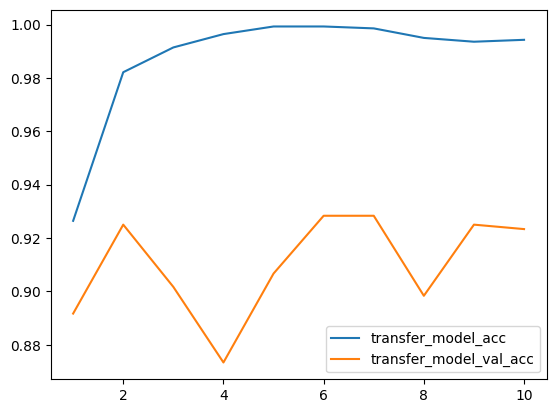

In [38]:
plt.plot(range(1,len(transfer_his.history['accuracy'])+1), transfer_his.history['accuracy'], label = 'transfer_model_acc')
plt.plot(range(1,len(transfer_his.history['val_accuracy'])+1), transfer_his.history['val_accuracy'], label = 'transfer_model_val_acc')

plt.legend()
plt.show()